In [ ]:
from terminal_optimization.infrastructure import quay_object

# simulation parameters (year, window, triggers)

# generate trend

# define port at t =0
terminal.quays = []
terminal.berths = []

# business logic
terminal = simulate(year, window, trend, terminal)        

# postprocessing
npv = npv(terminal)

# plotting
terminal_optimization.plot.cashflow_overview(terminal.quays[0])

In [1]:
import json
import numpy as np
import pandas as pd

In [2]:
import terminal_optimization.plot_file as plot_file
from terminal_optimization.forecast import maize, soybean, wheat, \
                                           handysize, handymax, panamax
import terminal_optimization.infrastructure       as infra
import terminal_optimization.investment_decisions as invest
import terminal_optimization.business_logic       as financial

## Methods and classes to move to package

In [6]:
class Terminal:
    pass

class Simulation_parameters:
    pass

class Decision_parameters:
    pass

In [10]:
startyear = 2018
simulation_window = 20
operational_hours = 365*24

simulation_parameters = Simulation_parameters()
simulation_parameters.start_year = startyear
simulation_parameters.simulation_window = simulation_window
simulation_parameters.operational_hours = operational_hours

In [ ]:
decision_parameters = Decision_parameters()


In [4]:

def simulate(simulation_parameters, decision_parameters, trends, terminal, vessels, commodities):

    years = range (simulation_parameters.start_year, simulation_parameters.start_year + simulation_parameters.simulation_window)
    for year in years:

        timestep = year - simulation_parameters.start_year
          
        ######################
        # Investment Decisions
        ######################           
        
        # Berths
        allowable_berth_occupancy = 0.15
        berths, cranes = invest.berth_invest_decision(
            terminal.berths, 
            terminal.cranes, 
            terminal.berth_objects, 
            allowable_berth_occupancy, 
            vessels, 
            year, timestep, simulation_parameters.operational_hours)

        # Quay
        quays = invest.quay_invest_decision(quays, berths, quay_object, year, timestep)

        # Cranes (NB: isn't this a double definition of cranes?)
        cranes = invest.crane_invest_decision(cranes, berths, cranes_object, year, timestep)
        
        # Storage
        storage_type            = 'Silos'
        trigger_throughput_perc = 10  # Percentage of annual throughput which triggers the investment in a new storage unit
        aspired_throughput_perc = 20  # Aspired of annual throughput which is realised due to the new storage unit
        storages = invest.storage_invest_decision(storages, storage_object, trigger_throughput_perc, aspired_throughput_perc, storage_type, commodities, year, timestep)

        # Loading stations
        station_utilisation     = 0.60 # Loading station utilisation
        trigger_throughput_perc = 80   # Percentage of hourly peak demand which triggers the investment in a new loading unit
        aspired_throughput_perc = 120  # Aspired percentage of hourly peak demand which is realised due to the new loading unit
        stations = invest.station_invest_decision(stations, station_object, station_utilisation, trigger_throughput_perc, aspired_throughput_perc, commodities, year, timestep, operational_hours)

        # Conveyors
        q_conveyors = invest.quay_conveyor_invest_decision(q_conveyors, cranes, quay_conveyor_object, year, timestep, operational_hours)
        h_conveyors = invest.hinterland_conveyor_invest_decision(h_conveyors, stations, hinterland_conveyor_object, year, timestep, operational_hours)

        # add objects to terminal 
        for berth in berths:
            terminal.berths.append(berth)
            
        for crane in cranes:
            terminal.cranes.append(crane)

        for quay in quays:
            terminal.quays.append(quay)
            
        for storage in storages:
            terminal.storages.append(storage)
            
        for station in stations:
            terminal.stations.append(station)
            
        for q_conveyor in q_conveyors:
            terminal.q_conveyors.append(q_conveyor)

        for h_conveyor in h_conveyors:
            terminal.h_conveyors.append(h_conveyor)

        ######################
        # Business Logic
        ######################

        # Terminal throughput
        throughputs = financial.throughput_calc(throughputs, commodities, \
                                                terminal.berths, cranes, year, timestep, operational_hours)

        # Revenues
        revenues = financial.revenue_calc(revenues, commodities, throughputs, year, timestep)

        # Capex
        capex = financial.capex_calc(capex, quays, cranes, storage, stations, q_conveyors, h_conveyors, year, timestep)

        # Labour costs
        labour = financial.labour_calc(labour, cranes, storage, stations, q_conveyors, h_conveyors, year, timestep, operational_hours)

        # Maintenance costs
        maintenance = financial.maintenance_calc(maintenance, quays, cranes, storage, stations, q_conveyors, h_conveyors, year, timestep)

        # Energy costs
        energy = financial.energy_calc(energy, berths, cranes, storage, stations, q_conveyors, h_conveyors, year, operational_hours, timestep)

        # Insurance costs
        insurance = financial.insurance_calc(insurance, quays, cranes, storage, stations, q_conveyors, h_conveyors, year, timestep)

        # Lease costs 
        lease = financial.lease_calc(lease, year,timestep)

        # Demurrage costs
        demurrage = financial.demurrage_calc(demurrage, year, berths, handysize, handymax, panamax, timestep)

        # Residual value calculations 
        residuals = financial.residual_calc(residuals, quays, cranes, storage, stations, q_conveyors, h_conveyors, assets, year, timestep)

        # Profits
        profits = financial.profit_calc(profits, revenues, capex, labour, maintenance, energy, insurance, lease, demurrage, residuals, simulation_window, timestep, year, start_year)
        
        # Opex
        opex = financial.opex_calc(opex, labour, maintenance, energy, insurance, lease, demurrage, year, timestep)
        
        # WACC depreciated profits
        #profits_WACC = financial.WACC_calc(profits, simulation_window)
    terminal = Terminal()
    quays, berths, cranes, storage, stations, q_conveyors, h_conveyors, throughputs, revenues, capex, labour, maintenance, energy, insurance, lease, demurrage, residuals, profits, opex            
    return terminal


In [52]:
terminal.quays = quays

## 1. Prepare calculation input (I/O)

### Main calculation parameters

In [18]:
simulation_window = 20     # looking 20 years ahead
start_year        = 2018   # start year of simulation
operational_hours = 365*24 # operational hours per year

### Estimate trend

#### Linear

In [22]:
# Maize - Linear demand
demand_maize  = 1000000        # demand at t=0
growth_maize  = 100000  

maize.linear_forecast        (year, simulation_window, demand_maize, growth_maize)

#### Exponential

In [23]:
# Soybean - Exponential demand
demand_soybean = 1000000
rate_soybean   = 1.06          # year on year growth rate of demand (% points) - input for constant method and random method

soybean.exponential_forecast (year, simulation_window, demand_soybean, rate_soybean)

#### Probabilistic

In [24]:
# Wheat - Probabilistic demand
demand_wheat   = 1000000
rate_wheat     = 1.05
mu_wheat       = 0.01          # avg bonus rate added to base rate (% points)  - input for random method
sigma_wheat    = 0.015         # standard deviation of bonus rate (% points)   - input for random method

wheat.random_forecast        (year, simulation_window, demand_wheat, rate_wheat, mu_wheat, sigma_wheat)

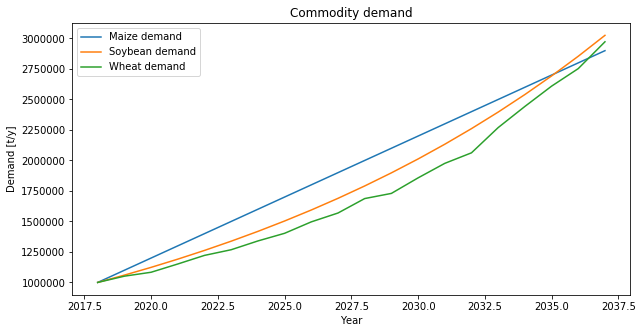

In [21]:
# Plot forecasts
plot_file.trend(maize, soybean, wheat, 10, 5)

### Specify terminal status @ t=0

In [44]:
quays, berths, cranes, storages, stations, q_conveyors, h_conveyors = [], [], [], [], [], [], []

quays.append(infra.quay_object)      
berths.append(infra.berth_object)     
cranes.append(infra.cranes_object[0])     
cranes.append(infra.cranes_object[1])     
cranes.append(infra.cranes_object[2])     
cranes.append(infra.cranes_object[3])     
storage.append(infra.storage_object)    
stations.append(infra.station_object)   
q_conveyors.append(infra.quay_conveyor_object) 
h_conveyors.append(infra.hinterland_conveyor_object)

throughputs, revenues, capex, labour, maintenance, energy,\
    insurance, lease, demurrage, residuals, profits, opex = \
    [], [], [], [], [], [], [], [], [], [], [], []

### Specify vessels and commodities

In [46]:
vessels       = [handysize, handymax, panamax]
commodities   = [maize, soybean, wheat]

# 2. Perform simulation

In [10]:
terminal = simulate(start_year, simulation_window, trends, terminal)

In [11]:
quays, berths, cranes, storage, stations, q_conveyors, h_conveyors, throughputs, revenues, capex, labour, maintenance, energy, insurance, lease, demurrage, residuals, profits, opex = simulate(start_year, simulation_window)

0
Are you sure that copy will work?
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


# 4 Preliminary Plots
### Profit/loss

In [ ]:
# Plotting annualised profits
plot_file.profit_loss(profits, 10, 5)

### Annual cashflows

In [ ]:
# Plotting yearly cashflows
plot_file.all_cashflows(revenues, capex, labour, maintenance, energy, insurance, demurrage, residuals, 10, 5)

### Demand vs. Capacity

In [ ]:
# Plotting capacity vs. demand 
plot_file.throughput(commodities, throughputs, 10, 5)

# 5 NPV

In [ ]:
#NPV = financial.NPV_calc(profits_WACC)
#NPV